In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from tqdm import tqdm
import pdb
from google.colab.patches import cv2_imshow
from functools import reduce 
import math

In [2]:
def draw_mat(mat):
  plt.imshow(mat,cmap = 'gray',  interpolation = 'none', vmin=0, vmax=1)
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

In [3]:
w, h = 0, 0

In [4]:
path = "/content/masks/*.*"
masks = []
files = glob.glob(path)
files.sort()
for file in files[1:20]:
   mask = scipy.io.loadmat(file)
   w, h = mask['mask'].shape
   masks.append(list(mask['mask'].flatten()))
masks = np.array(reduce(lambda a, b: a+b, masks))

In [14]:
def normal_image(img):
  flat_img = []
  for row in img:
    for pixel in row:
      b, g, r = pixel
      r = int(r)
      g = int(g)
      b = int(b)
      s = r + g + b
      # if s > 0:
      #   r /= s
      #   g /= s
      #   b /= s
      flat_img.append([r, g, b])
  flat_img = np.array([np.array(row) for row in flat_img])
  return flat_img

In [15]:
images = []
path = "/content/images/*.*"
files = glob.glob(path)
files.sort()
for file in tqdm(files[1:20]):
   img =  cv2.imread(file)
   images.append(list(normal_image(img)))
images = np.array(reduce(lambda a, b: a+b, images))

100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


In [16]:
masked = []
non_masked = []
pen_mat = []
av = np.zeros((3,))
for (i, (m, vec)) in tqdm(enumerate(zip(masks, images))):
  if m == 1:
    if len(masked) >= 21300 and len(masked) <= 21500:
      av += vec
      pen_mat.append(1)
    else:
      pen_mat.append(0)
    masked.append(vec)
  elif m == 0:
    pen_mat.append(0)
    non_masked.append(vec)

av /= sum(pen_mat)
# pen_mat = np.array(pen_mat)
# pen_mat = pen_mat.reshape((w, h))
# draw_mat(pen_mat)
masked = np.array(masked)
non_masked = np.array(non_masked)
print(av)

2861803it [00:11, 240149.93it/s]


[158.02985075 115.56716418  75.07960199]


In [17]:
def build_model(vecs):
  miu = np.zeros((3,))
  for vec in vecs:
    miu += vec
  miu /= len(vecs)
  sig = np.zeros((3, 3))
  for vec in vecs:
    diff = vec - miu
    sig += diff.reshape((3, 1)) * diff.reshape(1, 3)
  sig /= len(vecs)
  print(miu)
  print(sig)
  print()
  det = np.linalg.det(sig)
  inv = np.linalg.inv(sig)

  def P(vec):
    dn = (2 * math.pi) ** (3/2) * math.sqrt(det)
    up = math.exp(-0.5 * (vec.reshape(1, 3) @ inv @ vec.reshape(3, 1)))
    return up / dn
  
  return P

p_masked = build_model(masked)
p_non_masked = build_model(non_masked)

[161.97856753 122.96183404 102.00534689]
[[3201.77857327 2629.77991941 2303.20488735]
 [2629.77991941 2400.44764045 2165.37421696]
 [2303.20488735 2165.37421696 2200.67978987]]

[106.64309869 103.52679779 102.68804962]
[[6587.73340591 6416.80376686 5801.28528098]
 [6416.80376686 6648.29427749 6349.93275475]
 [5801.28528098 6349.93275475 6714.29841928]]



In [18]:
prior = {'face': 0.22194392442521707, 'non-face': 0.778056075574783}

In [34]:
def classifier(test):
  cnt = 0
  predicted = np.zeros(len(test))

  for i in range(len(test)):

    probabilities = {'face': 0, 'non-face': 0}

    probabilities['face'] = prior['face'] * p_masked(test[i])
    probabilities['non-face'] = prior['non-face'] * p_non_masked(test[i])

    bestLabel, bestProb = None, -1

    if probabilities['face'] >= probabilities['non-face']:
      cnt += 1
      predicted[i] = 255
    else:
      predicted[i] = 0
  return predicted

[0. 0. 0. ... 0. 0. 0.]
(480, 386)


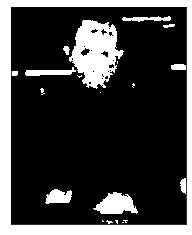

In [35]:
test_image = cv2.imread("img_02.jpg")
test = normal_image(test_image)
mx = np. array([0, 0, 0])
prediction = classifier(test)
print(prediction)
print((test_image.shape[0], test_image.shape[1]))
prediction = prediction.reshape((test_image.shape[0], test_image.shape[1]))
plt.imshow(prediction,cmap = 'gray',  interpolation = 'none', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [28]:
def mae(y_true, predictions):
    return np.mean(np.abs(y_true - predictions))

In [36]:
average_error = 0
for i in range(1, 4):
  test_i = cv2.imread("img_0{j}.jpg".format(j = i))
  prediction = classifier(normal_image(test_i)).reshape((test_i.shape[0], test_i.shape[1]))
  mask_test_i = scipy.io.loadmat("mask_0{j}.mat".format(j = i))
  y_true = mask_test_i['mask']
  average_error += mae(y_true, prediction/255)
average_error / 3

0.090503162380861